In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

while 'notebooks' in os.getcwd():
    os.chdir('..')

import torch
import torch_geometric.transforms as T
from ogb.nodeproppred import PygNodePropPredDataset, Evaluator
from sklearn.metrics import roc_auc_score
import logging
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.offline as pyo
import numpy as np
import pandas as pd

from src.torch_geo_models import GraphSAGE, LinkPredictor
from src.data.gamma.positional_citeseer import load_dataset, get_train_val_test_edges_auc,\
    get_val_test_edges_link_pred, prepare_adjencency, get_edge_index_from_adjencency
from src.train.positional_omega.graph_sage import PositionalOmegaGraphSageCosSim

/home/caiolmartinelli/.cache/pypoetry/virtualenvs/arxiv-paperclassification-f16XUvnj-py3.10/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
logging.basicConfig(
    format='%(asctime)s - %(levelname)s : %(message)s',
    level=logging.INFO,
    datefmt='%Y-%m-%d %H:%M:%S',
    filename='logs/omega_function/citeseer/01-1-positional_omega_graph_sage_cossim.log'
)

In [5]:
torch.cuda.is_available()

True

In [6]:
device = f'cuda:0' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
device

device(type='cuda', index=0)

## Data Loading

In [7]:
dataset = load_dataset()

data, edges_train_auc, edges_val_auc, edges_test_auc =\
    get_train_val_test_edges_auc(dataset, device=device)

data, edges_val, edges_test, neg_edges_val, neg_edges_test =\
    get_val_test_edges_link_pred(data, remove_from_data=True, device=device)

data = prepare_adjencency(data, to_symmetric=True)

edge_index = get_edge_index_from_adjencency(data, device)

Processing...
Done!


## Training

In [8]:
for run in range(30):
    for n_layers in range(1, 4):
        omega = PositionalOmegaGraphSageCosSim(
            device=device,
            num_nodes=data.num_nodes,
            dataset='citeseer',
            n_layers=n_layers,
            run=run)
        torch.cuda.empty_cache()
        omega.train(edge_index,
                    edges_val,
                    edges_test,
                    neg_edges_val,
                    neg_edges_test,
                    edges_train_auc,
                    edges_val_auc,
                    edges_test_auc,
                    data.adj_t,
                    data.y)
        omega.discard_run_not_optimal_models()

## Results

### For a layer number

In [9]:
n_layers = 1

In [10]:
metrics = PositionalOmegaGraphSageCosSim.read_metrics(
    n_layers=n_layers,
    dataset='citeseer'
)
print(metrics.shape)
metrics.head()

(6030, 9)


,n_layers,run,epoch,loss_train,loss_val,loss_test,auc_train,auc_val,auc_test
0,1,0,0,None,1.608078,1.604622,0.560569,0.499637,0.520861
1,1,0,1,1.6062527894973755,1.587403,1.581946,0.566914,0.507606,0.534788
2,1,0,2,1.5838946104049683,1.558025,1.550772,0.569416,0.508123,0.545563
3,1,0,3,1.5537532567977905,1.519178,1.509631,0.569892,0.510179,0.550144
4,1,0,4,1.5138500928878784,1.471394,1.459765,0.569099,0.509703,0.552337


### Sumarize metrics per epoch

In [11]:
metrics_cols = metrics.columns[3:]
metrics_cols

Index(['loss_train', 'loss_val', 'loss_test', 'auc_train', 'auc_val',
       'auc_test'],
      dtype='object')

In [12]:
metrics['loss_train'] = metrics\
    .replace('None', np.nan)\
    ['loss_train']\
    .astype(float)

In [13]:
epoch_metrics = metrics\
    .fillna(-1)\
    .groupby('epoch')\
    [metrics_cols]\
    .agg(['mean', 'std'])
epoch_metrics.columns = [f'{x[0]}_{x[1]}' for x in epoch_metrics.columns]
epoch_metrics.head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
0,-1.000000,0.000000,1.605205,0.003031,1.604482,0.002634,0.542313,0.019656,0.510669,0.021901,0.531441,0.016121
1,1.604954,0.002754,1.582487,0.005437,1.581501,0.004998,0.558934,0.012388,0.526760,0.017586,0.547904,0.014709
2,1.581913,0.005157,1.551153,0.008835,1.549812,0.008446,0.561904,0.010294,0.530701,0.013910,0.552266,0.013235
3,1.550026,0.008517,1.510395,0.013044,1.508707,0.012765,0.562497,0.009685,0.531985,0.012551,0.553606,0.012258
4,1.508357,0.012867,1.460688,0.017419,1.459032,0.017234,0.562377,0.009836,0.533285,0.012188,0.554005,0.011737


In [14]:
epoch_metrics.sort_values('auc_val_mean', ascending=False).head()

,loss_train_mean,loss_train_std,loss_val_mean,loss_val_std,loss_test_mean,loss_test_std,auc_train_mean,auc_train_std,auc_val_mean,auc_val_std,auc_test_mean,auc_test_std
epoch,,,,,,,,,,,,
53,0.970536,0.003143,0.978893,0.015310,0.992492,0.017376,0.572230,0.009281,0.600204,0.011182,0.576980,0.006235
52,0.972123,0.003134,0.981111,0.015199,0.994717,0.017405,0.572164,0.009282,0.600193,0.011274,0.576693,0.006358
54,0.967971,0.004267,0.976705,0.015431,0.990298,0.017374,0.572294,0.009315,0.600184,0.010984,0.577238,0.006155
51,0.973877,0.003686,0.983322,0.015102,0.996984,0.017456,0.572086,0.009294,0.600162,0.011340,0.576400,0.006445
50,0.976353,0.002996,0.985534,0.015012,0.999309,0.017491,0.571990,0.009365,0.600157,0.011440,0.576132,0.006546


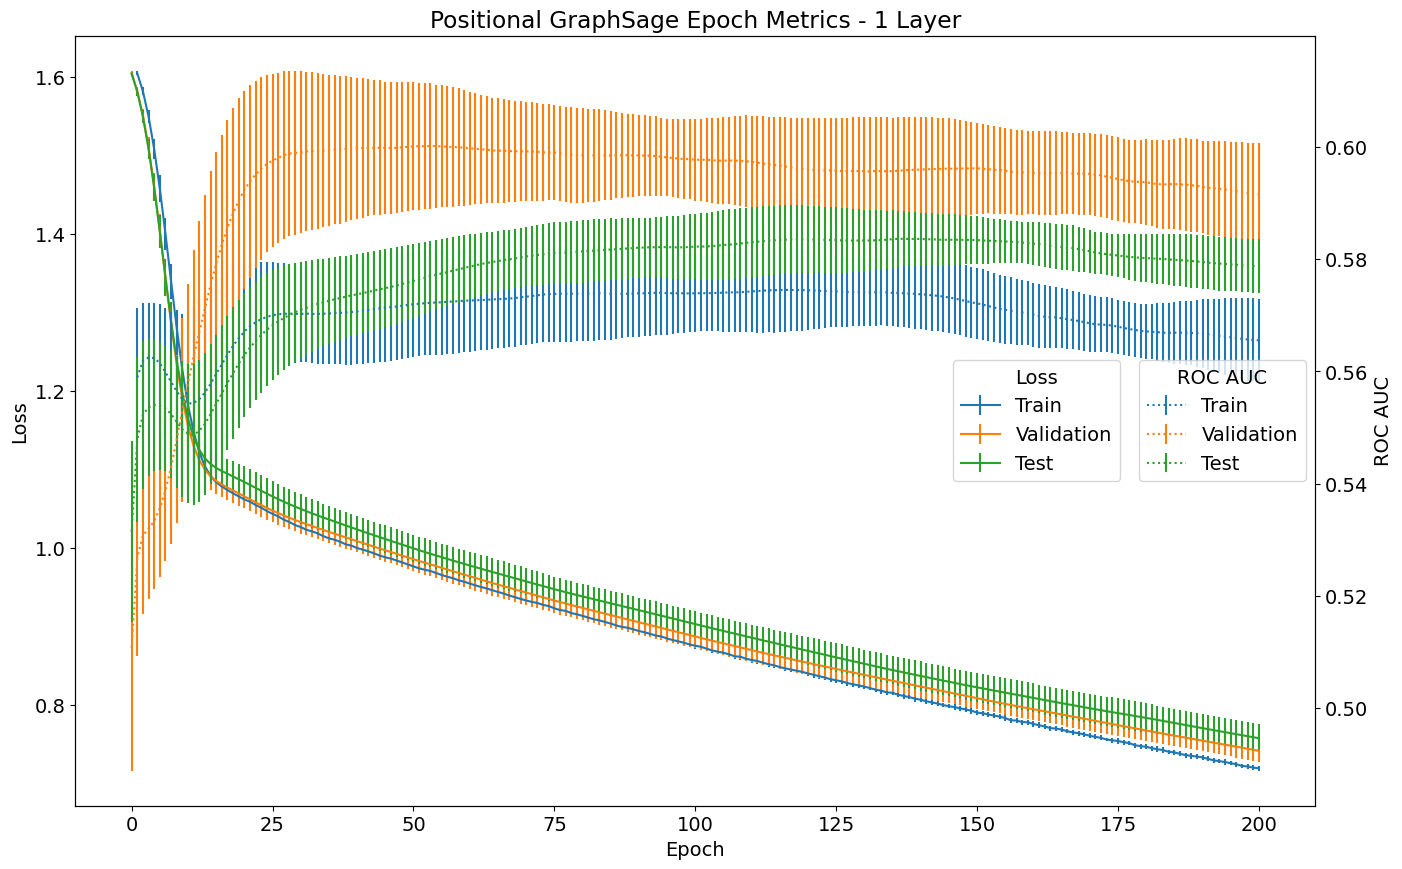

In [16]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title(f'Positional GraphSage Epoch Metrics - {n_layers} Layer')

ax1.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['loss_train_mean'][1:],
    yerr=epoch_metrics['loss_train_std'][1:],
    ls='-',
    label='Train')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_val_mean'],
    yerr=epoch_metrics['loss_val_std'],
    ls='-',
    label='Validation')

ax1.errorbar(
    epoch_metrics.index,
    epoch_metrics['loss_test_mean'],
    yerr=epoch_metrics['loss_test_std'],
    ls='-',
    label='Test')

ax1.legend(loc='center right', title='Loss', bbox_to_anchor=[0.85, 0.5])
ax1.set_ylabel('Loss')
ax1.set_xlabel('Epoch')

ax2 = ax1.twinx()

ax2.errorbar(
    epoch_metrics.index[1:],
    epoch_metrics['auc_train_mean'][1:],
    yerr=epoch_metrics['auc_train_std'][1:],
    ls=':',
    label='Train')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_val_mean'],
    yerr=epoch_metrics['auc_val_std'],
    ls=':',
    label='Validation')

ax2.errorbar(
    epoch_metrics.index,
    epoch_metrics['auc_test_mean'],
    yerr=epoch_metrics['auc_test_std'],
    ls=':',
    label='Test')

ax2.legend(loc='center right', title='ROC AUC', bbox_to_anchor=[1, 0.5])
ax2.set_ylabel('ROC AUC')

plt.savefig(f'reports/images/citeseer/positional_omega_graphsage_cossim_training_metrics_{n_layers}layers.pdf')

### Comparing Validation Performance for All Layer numbers

In [17]:
n_layers_list = range(1, 4)

In [18]:
mean_auc_val_dict = {}
mean_loss_val_dict = {}
std_auc_val_dict = {}
std_loss_val_dict = {}
for n_layers in n_layers_list:
    metrics = PositionalOmegaGraphSageCosSim.read_metrics(dataset='citeseer', n_layers=n_layers)
    mean_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].mean()
    
    auc_val = mean_df['auc_val']
    loss_val = mean_df['loss_val']
    mean_auc_val_dict[n_layers] = auc_val
    mean_loss_val_dict[n_layers] = loss_val

    std_df = metrics.groupby(['epoch'])[['auc_val', 'loss_val']].std()

    auc_val = std_df['auc_val']
    loss_val = std_df['loss_val']
    std_auc_val_dict[n_layers] = auc_val
    std_loss_val_dict[n_layers] = loss_val

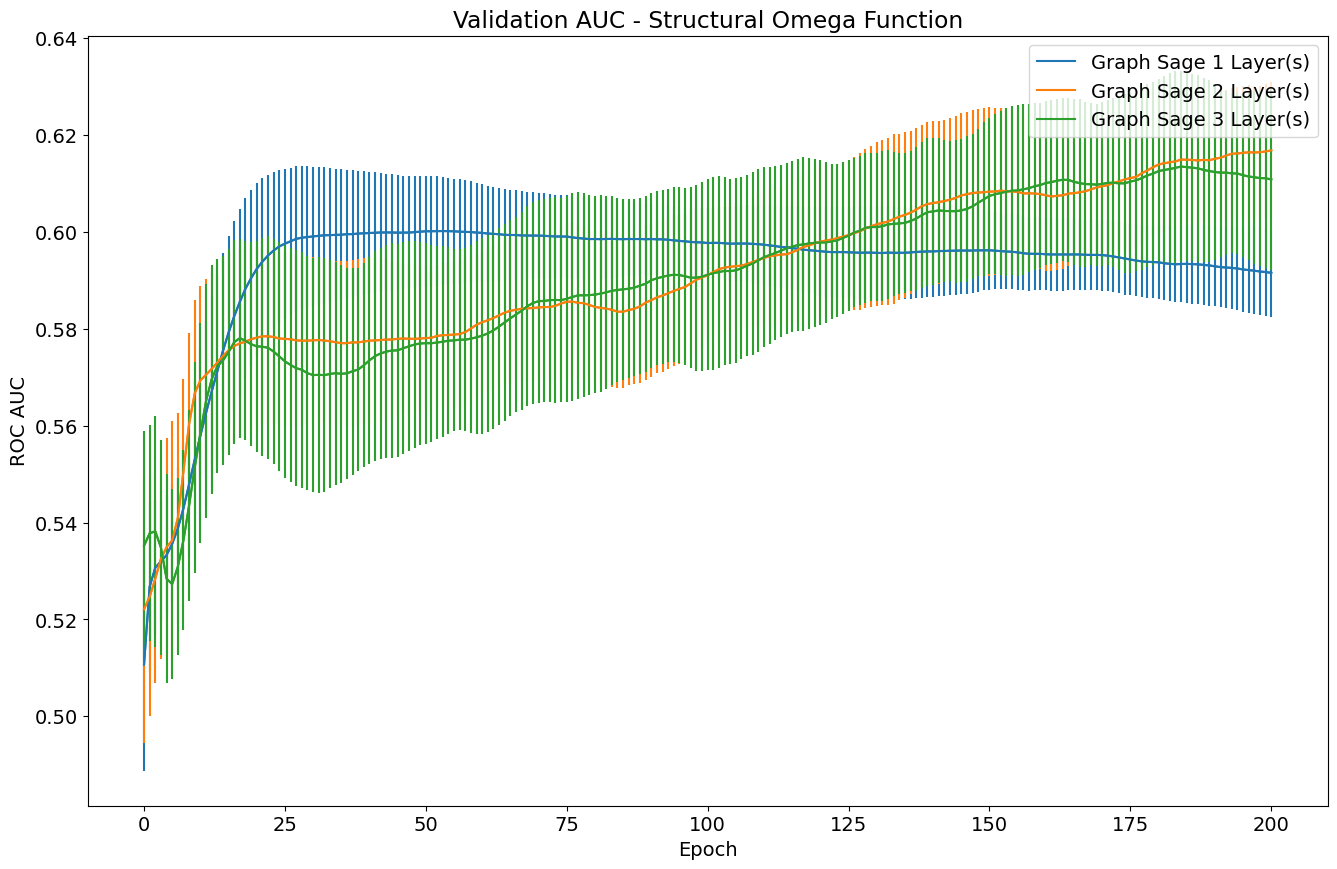

In [19]:
plt.rcParams['font.size'] = '14'
fig, ax1 = plt.subplots(1, 1, figsize=(16, 10))

ax1.set_title('Validation AUC - Structural Omega Function')

for n_layers in mean_auc_val_dict:
    error_bar = ax1.errorbar(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        yerr=std_auc_val_dict[n_layers],
        ls='-',
        # label=f'Graph Sage {n_layers} Layer(s)',
    )

    color = error_bar[0].get_color()

    ax1.plot(
        mean_auc_val_dict[n_layers].index,
        mean_auc_val_dict[n_layers],
        # yerr=std_auc_val_dict[n_layers],
        ls='-',
        label=f'Graph Sage {n_layers} Layer(s)',
        color=color,
    )

# ax1.set_xlim(-50, 5000)

ax1.set_xlabel('Epoch')
ax1.set_ylabel('ROC AUC')

ax1.legend()

In [20]:
error_bar[0].get_color()

'#2ca02c'

## Score Best model

In [21]:
best_model_metrics = metrics.sort_values('auc_val', ascending=False).iloc[0]
best_model_metrics

n_layers                       3
run                            8
epoch                        178
loss_train    0.7433852553367615
loss_val                0.729291
loss_test               0.736813
auc_train               0.582552
auc_val                 0.650437
auc_test                0.592401
Name: 1786, dtype: object

In [ ]:
best_model_metrics.to_json('models/positional_omega_graph_sage_cossim/citeseer/best_model_info.json')